# Вебинар 2. Бейзлайны и детерминированные алгоритмы item-item

Задача рекомендаций:
1. Мало товаров - предсказание покупки (регрессия)
2. Много товаров, есть разметка релевантности - задача ранжирования (эмбеддинги)
3. Много товаров, купил/не купил - рекомендательные системы (детерменированные, ALS, на основе контента)
4. Много товаров, есть ограничения на коммуникацию - uplift (деревья)

Везде можно применять ансамбли и стеккинг моделей

[RecSys types](https://drive.google.com/file/d/10i5oN2Cw60oLMvnQ4SKFkkotnhRS7Q8L/view?usp=sharing)

In [1]:
pip install implicit

  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'


  ERROR: Command errored out with exit status 1:
   command: 'c:\users\пк\appdata\local\programs\python\python39\python.exe' 'C:\Users\ПК\AppData\Local\Temp\pip-standalone-pip-lmu99mdu\__env_pip__.zip\pip' install --ignore-installed --no-user --prefix 'C:\Users\ПК\AppData\Local\Temp\pip-build-env-vx8dyoh5\overlay' --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- 'setuptools>=42' wheel scikit-build@git+https://github.com/scikit-build/scikit-build.git 'Cython>=0.24' 'scipy>=0.16'
       cwd: None
  Complete output (40 lines):
    Cloning https://github.com/scikit-build/scikit-build.git to c:\users\пк\appdata\local\temp\pip-install-n6qmn8al\scikit-build_24ea2f115bf94e1eb29322617513675a
    Running command git clone --filter=blob:none -q https://github.com/scikit-build/scikit-build.git 'C:\Users\ПК\AppData\Local\Temp\pip-install-n6qmn8al\scikit-build_24ea2f115bf94e1eb29322617513675a'
    Resolved https://github.com/scikit-build/scikit-build.gi

  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for implicit: filename=implicit-0.4.8-cp39-cp39-win_amd64.whl size=624372 sha256=2ab554a821e98d5d68a3fb14a9b56a7b94c05a406eefec5edb57d1a75eff54b8
  Stored in directory: c:\users\пк\appdata\local\pip\cache\wheels\2d\0a\a4\6aea635157daf166f50276da2f2ceb04d17f5e37cb3f171ac7
Successfully built implicit


        import setuptools_scm  # noqa: F401
    ModuleNotFoundError: No module named 'setuptools_scm'
    ----------------------------------------
    Using cached setuptools-60.8.2-py3-none-any.whl (1.1 MB)
    Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  ERROR: Could not find a version that satisfies the requirement scikit-build (unavailable) (from versions: 0.1.0, 0.2.0, 0.3.0, 0.4.0, 0.5.0, 0.5.1, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.8.0, 0.8.1, 0.9.0, 0.10.0, 0.11.0, 0.11.1, 0.12.0, 0.13.0, 0.13.1)
  ERROR: No matching distribution found for scikit-build (unavailable)
  You should consider upgrading via the 'c:\users\пк\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.
  ----------------------------------------
  ERROR: Command errored out with exit status 1:
   command: 'c:\users\пк\appdata\local\programs\python\python39\python.exe' 'C:\Users\ПК\AppData\Local\Temp\pip-standalone-pip-y8enomz0\__env_pip__.zip\pip' install --ignore-install

[Implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) - очень быстрая и 
эффективная библиотека для рекоммендаций

Основные фичи:
    - Cython под капотом - высокая скорость
    - Множество приближенных алгоритмов - быстрее, чем оригинальные
    - Содежрит большинство популярных алгоритмов
    - Есть алгоритмы ранжирования
    - Поиск похожих товаров / юзеров
    - Есть возможность пересчета "холодного" юзера "на лету"
    - Возможность фильтровать товары при рекомендациях (Например, не рекомендовать женские товары мужчинам)
    - Есть метрики качества

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [3]:
data = pd.read_csv('retail_train.csv')
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [4]:
data['week_no'].nunique()

95

In [5]:
data.shape

(2396804, 12)

In [6]:
users, items, interactions = data.user_id.nunique(), data.item_id.nunique(), data.shape[0]

print('# users: ', users)
print('# items: ', items)
print('# interactions: ', interactions)

# users:  2499
# items:  89051
# interactions:  2396804


In [7]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()
popularity.describe()

,item_id,sales_value
count,8.905100e+04,89051.000000
mean,5.115772e+06,83.458481
std,5.178973e+06,1628.715079
min,2.567100e+04,0.000000
25%,9.665830e+05,3.500000
50%,1.448516e+06,10.780000
75%,9.553042e+06,46.105000
max,1.802456e+07,467993.620000


In [8]:
popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
popularity.describe()

,item_id,user_id
count,8.905100e+04,89051.000000
mean,5.115772e+06,14.759767
std,5.178973e+06,45.904111
min,2.567100e+04,1.000000
25%,9.665830e+05,1.000000
50%,1.448516e+06,2.000000
75%,9.553042e+06,10.000000
max,1.802456e+07,2039.000000


**Note:**  
Еще есть данные по характеристикам товаров и пользователей. Они нам пригодятся через несколько вебинаров

### Train-test split

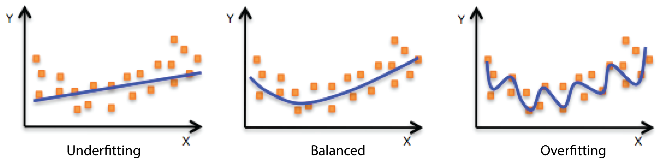

В рекомендательных системах корректнее использовать train-test split по времени, а не случайно  
Я возьму последние 3 недели в качестве теста

In [9]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [10]:
data_train.shape[0], data_test.shape[0]

(2278490, 118314)

# 1. Бейзлайны

Создадим датафрейм с покупками юзеров на тестовом датасете (последние 3 недели)

In [11]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [12]:
test_users = result.shape[0]
new_test_users = len(set(data_test['user_id']) - set(data_train['user_id']))

print('В тестовом дата сете {} юзеров'.format(test_users))
print('В тестовом дата сете {} новых юзеров'.format(new_test_users))

В тестовом дата сете 2042 юзеров
В тестовом дата сете 0 новых юзеров


### 1.1 Random recommendation

In [13]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [14]:
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [15]:
%%time

items = data_train.item_id.unique()

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

Wall time: 4.36 s


In [16]:
items

array([ 1004906,  1033142,  1036325, ..., 15722756, 17170636, 15716393],
      dtype=int64)

In [17]:
result.head(2)

,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[977677, 740677, 1538543, 865598, 9494091]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1480232, 9297310, 1930402, 13095004, 9297348]"


### 1.2 Popularity-based recommendation

In [18]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    #print(recs)
    return recs.tolist()

In [19]:
%%time

# Можно так делать, так как рекомендация не зависит от юзера
popular_recs = popularity_recommendation(data_train, n=5)

result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)

Wall time: 179 ms


In [20]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[977677, 740677, 1538543, 865598, 9494091]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1480232, 9297310, 1930402, 13095004, 9297348]","[6534178, 6533889, 1029743, 6534166, 1082185]"


### 1.3 Weighted random recommender

- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

*Пример*  
item_1 - 5, item_2 - 7, item_3 - 4  # / sum  
item_1 - 5 / 16, item_2 - 7 / 16, item_3 - 4 / 16

**HW 02. Task 1**

Использован цикл для исключения дубликатов.
random.choice по какой-то причине все же возвращает, скорее всего из-за учета весов.

In [21]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    items = np.array(items_weights['item_id'])
    #print(items)
    weights = np.array(items_weights['norm'])
    
    #print(weights)
    recs = []
    while len(recs) < n:
      item = np.random.choice(items, 
                            size=1, 
                            replace=False,
                            p=weights)      
      if item not in recs:
        recs.append(item)
          
    return recs

В качестве веса принято произведение количества покупок на объем покупки. 
И затем веса приведены к сумме 1.

In [22]:
weighted_df = data_train.copy()
weighted_df['weight'] = weighted_df['quantity'] * weighted_df['sales_value']
weighted_df.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,weight
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,0.99
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.21
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.50


In [23]:
weighted_df['norm'] = weighted_df['weight']/weighted_df['weight'].sum()

In [24]:
weighted_df.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,weight,norm
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.39,1.917268e-10
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.82,1.131050e-10
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,0.99,1.365536e-10
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.21,1.668988e-10
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.50,2.068994e-10


In [25]:
weighted_df['norm'].sum()

1.0000000000000009

In [26]:
%%time

# your_code
random_weighted_recs = weighted_random_recommendation(weighted_df, n=10)

Wall time: 10.6 s


Результат подбора:

In [27]:
random_weighted_recs

[array([6534178], dtype=int64),
 array([6533889], dtype=int64),
 array([6544236], dtype=int64),
 array([6534166], dtype=int64),
 array([397896], dtype=int64),
 array([1404121], dtype=int64),
 array([964968], dtype=int64),
 array([480014], dtype=int64),
 array([1426702], dtype=int64),
 array([5703832], dtype=int64)]

### Выводы по бейзлайнам
- Фиксируют базовое качество;
- Бейзлайны могут быть фильтрами;
- Иногда бейзлайны лучше ML-модели

# 2. Детерминированные алгоритмы item-item

## 2.1 Item-Item Recommender / ItemKNN

[user_item_matrix](https://drive.google.com/file/d/1AtgrATUQ3F60thVGTAN7bpHSSaSESzxP/view?usp=sharing)

То, что именно находится в матрице user-item нужно определять из бизнес-логики

Варианты для нашего датасета(не исчерпывающий список):
    - Факт покупки (0 / 1)
    - Кол-во покупок (count)
    - Сумма покупки, руб
    - ...
    
**Детерминированные алгоритмы**:
    - Предсказывают те числа, которые стоят в матрице

**ML-алгоритмы (большинство)**:
    - В качестве *таргетов* "под капотом" принимают 0 и 1 (в ячейке не 0 -> таргет 1)
    - А абсолютные значения воспринимают как *веса ошибок*
    
*P.S.* На самом деле есть много трюков, как можно заполнять матрицу user-item. Об этом мы поговорим на следующих вебинарах

**Как работает User-User Recommender**

[user_user_recommender](https://drive.google.com/file/d/1qg_ecgjNmymQtfNchzAwxdLCbDXga69Q/view?usp=sharing)

*Шаг 1:* Ищем K ближайших юзеров к целевому юзеру  
*Шаг 2*: predict "скора" товара = среднему "скору" этого товара у его соседей  
*Шаг 3*: Сортируем товары по убыванию predict-ов и берем топ-k

----
**(!) Важно** 
- У item-item алгоритмов большая сложность predict ($O(I^2 log(I))$ или $O(I^3)$, в зависимости от реализации 
- Если в датасете много item_id, то item-item модели ОЧЕНЬ долго предсказывают. Со всеми товарами predict на тесте ~2 часа
- Давайте возьмем из ~90к товаров только 5k самых популярных 

*P.S.*  Брать топ-Х популярных и рекомендовать только из них - очень популярная стратегия.   
*P.P.S.*  В рекомендательных системах много таких трюков. Что-то подобное в курсе вы увидите еще не раз

In [28]:
data.item_id.nunique()

89051

In [29]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [30]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [31]:
len(top_5000)

5000

In [32]:
data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [34]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

c:\users\пк\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [35]:
data_train.item_id.nunique()

5001

In [36]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', 
                                  columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
sparse_user_item

<2499x5001 sparse matrix of type '<class 'numpy.float64'>'
	with 667080 stored elements in Compressed Sparse Row format>

In [38]:
user_item_matrix.shape

(2499, 5001)

In [39]:
user_item_matrix.sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100

5.33770796861036

In [40]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [41]:
matrix_itemids

array([   0,    1,    2, ..., 4998, 4999, 5000])

In [42]:
user_item_matrix

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 913 ms


In [44]:
data_test.user_id.describe()

count    118314.000000
mean       1274.589499
std         718.479723
min           1.000000
25%         679.000000
50%        1282.000000
75%        1917.000000
max        2500.000000
Name: user_id, dtype: float64

In [45]:
userid_to_id[13]

12

In [46]:
recs = model.recommend(userid=userid_to_id[13],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

In [47]:
recs

[(2381, 98195.0),
 (3408, 90149.0),
 (2148, 72193.0),
 (3587, 19332.0),
 (3947, 19126.0)]

In [48]:
recs[0][0]

2381

In [49]:
[id_to_itemid[rec[0]] for rec in recs]

[999999, 1082185, 981760, 1098066, 1127831]

In [50]:
itemid_to_id[999999]

2381

In [51]:
%%time

result['itemitem'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)
                    ])

Wall time: 81 ms


In [52]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[977677, 740677, 1538543, 865598, 9494091]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1480232, 9297310, 1930402, 13095004, 9297348]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]"


### 4.2 Косинусное сходство и CosineRecommender

[cosine_similarity](https://drive.google.com/file/d/10kFby5sc2x3aObQHRRyF2Nn9KC2URyCS/view?usp=sharing)

In [53]:
%%time

model = CosineRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 1.21 s


In [54]:
recs

[(3408, 45.02431609428097),
 (2381, 23.57630378858287),
 (2148, 22.011829058022414),
 (3947, 17.7780787439075),
 (3587, 10.642785799960672)]

In [55]:
[id_to_itemid[rec[0]] for rec in recs]

[1082185, 999999, 981760, 1127831, 1098066]

In [56]:
%%time

result['cosine'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)])

Wall time: 102 ms


In [57]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[977677, 740677, 1538543, 865598, 9494091]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1480232, 9297310, 1930402, 13095004, 9297348]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]"


### 4.3 TF-IDF взвешивание и TFIDFRecommender

[tf_idf](https://drive.google.com/file/d/1jEGMzgOCn-dB6F1DqYRZ0RWU0Dcr6h5Q/view?usp=sharing)

Если 2 юзера оба купили очень популярный товар, то это еще не значит,что они похожи   
Если 2 юзера оба купили редкий товар, то они похожи

Занижаем вес популярных товаров при расчете расстояний между пользователями

In [58]:
%%time

model = TFIDFRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 1.25 s


In [59]:
[id_to_itemid[rec[0]] for rec in recs]

[1082185, 981760, 1127831, 999999, 1098066]

In [60]:
%%time

result['tfidf'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)])

Wall time: 100 ms


In [61]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[977677, 740677, 1538543, 865598, 9494091]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1480232, 9297310, 1930402, 13095004, 9297348]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]"


### 4.4 Трюк - по истории конкретного пользователя (K=1)

In [62]:
%%time

model = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 1.23 s


In [63]:
[id_to_itemid[rec[0]] for rec in recs]

[999999, 1082185, 1029743, 995785, 1004906]

In [64]:
%%time

result['own_purchases'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)])

Wall time: 56 ms


### 4.5 Измерим качество по precision@5

In [65]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[977677, 740677, 1538543, 865598, 9494091]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1480232, 9297310, 1930402, 13095004, 9297348]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]"


In [66]:
result.to_csv('predictions_basic.csv', index=False)

Можно ли улучшить бейзлайны, если считать их на топ-5000 товарах?

In [72]:
# your_code
# заведем еще один датасет, но с ограничением по присутсвию товаров только из 5000 самых популярных.
# Весь остальной процессинг будет идти параллельно для обоих датасетов для сравнения метрик на выходе.
data_train_5000 = data_train.copy()
data_train_5000.loc[~data_train_5000['item_id'].isin(top_5000), 'item_id']

6          999999
8          999999
9          999999
10         999999
12         999999
            ...  
2282311    999999
2282314    999999
2282315    999999
2282316    999999
2282321    999999
Name: item_id, Length: 829774, dtype: int64

In [74]:
data_train_5000.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [76]:
data_train_5000.shape

(2278490, 12)

Повторим тот же набор шагов, но для модифицированного датасета

In [77]:
data_train_5000.item_id.nunique()

5001

### Item-Item

In [78]:
user_item_matrix_5000 = pd.pivot_table(data_train_5000, 
                                  index='user_id', 
                                  columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

In [79]:
user_item_matrix_5000[user_item_matrix_5000 > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix_5000 = user_item_matrix_5000.astype(float) # необходимый тип матрицы для implicit

In [80]:
# переведем в формат saprse matrix
sparse_user_item_5000 = csr_matrix(user_item_matrix_5000).tocsr()

In [85]:
user_item_matrix_5000.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
sparse_user_item_5000

<2499x5001 sparse matrix of type '<class 'numpy.float64'>'
	with 667080 stored elements in Compressed Sparse Row format>

In [86]:
userids_5000 = user_item_matrix_5000.index.values
itemids_5000 = user_item_matrix_5000.columns.values

In [87]:
matrix_userids_5000 = np.arange(len(userids_5000))
matrix_itemids_5000 = np.arange(len(itemids_5000))

In [88]:
id_to_itemid_5000 = dict(zip(matrix_itemids_5000, itemids_5000))
id_to_userid_5000 = dict(zip(matrix_userids_5000, userids_5000))

In [93]:
%%time

model_5000 = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model_5000.fit(csr_matrix(user_item_matrix_5000).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 962 ms


In [94]:
data_test.user_id.describe()

count    118314.000000
mean       1274.589499
std         718.479723
min           1.000000
25%         679.000000
50%        1282.000000
75%        1917.000000
max        2500.000000
Name: user_id, dtype: float64

In [95]:
# проводим рекомендации по всему датасету для модели, которая обучалась на 5000 самых популярных товаров
recs_5000 = model_5000.recommend(userid=userid_to_id[13],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix_5000).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)	

In [102]:
result['itemitem_5000'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model_5000.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)
                    ])

### Косинусное сходство и CosineRecommender

In [104]:
model_5000 = CosineRecommender(K=5, num_threads=4)

In [105]:
model_5000.fit(csr_matrix(user_item_matrix_5000).T.tocsr(), 
          show_progress=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

In [106]:
%time
result['cosine_5000'] = result['user_id'].\
    apply(lambda x: [id_to_itemid_5000[rec[0]] for rec in 
                    model_5000.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item_5000,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

Wall time: 0 ns


### По истории конкретного пользователя (K=1)

In [108]:
%%time

model_5000 = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

model_5000.fit(csr_matrix(user_item_matrix_5000).T.tocsr(), 
          show_progress=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 860 ms


In [111]:
%%time

result['own_purchases_5000'] = result['user_id'].\
    apply(lambda x: [id_to_itemid_5000[rec[0]] for rec in 
                    model_5000.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item_5000,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None,
                                    recalculate_user=False)])

Wall time: 66 ms


### tf-idf

In [122]:
%%time

model_5000 = TFIDFRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model_5000.fit(csr_matrix(user_item_matrix_5000).T.tocsr(), 
          show_progress=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 972 ms


In [123]:
%%time

result['tfidf_5000'] = result['user_id'].\
    apply(lambda x: [id_to_itemid_5000[rec[0]] for rec in 
                    model_5000.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item_5000,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=False)])

Wall time: 111 ms


### Метрики

In [112]:
# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#from src.metrics import precision_at_k, recall_at_k

In [113]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [114]:
result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean()

0.0005876591576885408

In [115]:
result.apply(lambda row: precision_at_k(row['popular_recommendation'], row['actual']), axis=1).mean()

0.15523996082272282

In [117]:
result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean()

0.15122428991185113

In [116]:
result.apply(lambda row: precision_at_k(row['itemitem_5000'], row['actual']), axis=1).mean()

0.13692458374143

In [118]:
result.apply(lambda row: precision_at_k(row['cosine'], row['actual']), axis=1).mean()

0.1551420176297747

In [119]:
result.apply(lambda row: precision_at_k(row['cosine_5000'], row['actual']), axis=1).mean()

0.1329089128305583

In [124]:
result.apply(lambda row: precision_at_k(row['tfidf'], row['actual']), axis=1).mean()

0.16092066601371205

In [125]:
result.apply(lambda row: precision_at_k(row['tfidf_5000'], row['actual']), axis=1).mean()

0.13898139079333988

In [121]:
result.apply(lambda row: precision_at_k(row['own_purchases'], row['actual']), axis=1).mean()

<ipython-input-113-3122f09163b9>:11: RuntimeWarning: invalid value encountered in long_scalars
  precision = flags.sum() / len(recommended_list)


0.20191740412979353

In [120]:
result.apply(lambda row: precision_at_k(row['own_purchases_5000'], row['actual']), axis=1).mean()

0.17998694090760692

#### Вывод

В данном конкретном случае обучение по 5000 товаров стабильно приводит к более низкой величине метрики.